# Implement a Linear Support Vector Machine (SVM)
Name : Suraj Istari Meshram

reading dataset
------------------------------------------------
Basic EDA On Dataset
shape of dataset : (569, 33)
applying features
splitting into train and test sets
------------------------------------------------
training started
Epoch is: 1 and Cost is: 7255.467837388561
Epoch is: 2 and Cost is: 6560.539650309443
Epoch is: 4 and Cost is: 5432.260727125548
Epoch is: 8 and Cost is: 3858.9068289937827
Epoch is: 16 and Cost is: 2677.7016699826986
Epoch is: 32 and Cost is: 1971.2372532830498
Epoch is: 64 and Cost is: 1585.2458111444835
Epoch is: 128 and Cost is: 1327.3372289430436
Epoch is: 256 and Cost is: 1159.716023153386
Epoch is: 512 and Cost is: 1077.050553503485
Epoch is: 1024 and Cost is: 1049.6149431875192
Epoch is: 2048 and Cost is: 1048.2527034644652
training finished.
weights are: [ 3.54620631 11.07148791 -2.29691152 -7.88047689 10.15372123 -1.26790941
 -6.44396879  2.24993684 -3.88357909  3.24957285  4.95340879  4.85196481
 -4.69620196]
testing the model
------------------

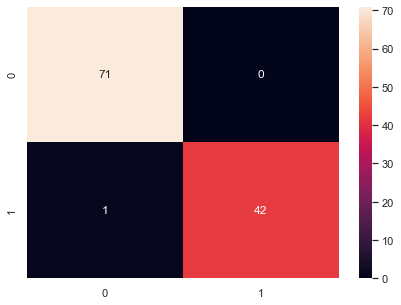

In [33]:
#Importing required Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score,confusion_matrix, classification_report
from sklearn.utils import shuffle

# define the function for features selction that help in filtering irrelevent or
#redundant features
def delete_correlated_features(x):
    corr_threshold = 0.9
    corr = x.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = x.columns[drop_columns]
    x.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped

def delete_unimp_featuress(x, y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(x.columns)):
        regression_ols = sm.OLS(y, x).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            x.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped
###################################################################

# Define the function for calculate the total cost to minimise the cost using gradient decent algo. and
# tuning paramter  C or lambda for wider margin and vice versa..

def calc_cost(w, x, y):
    #calculate Hinge loss
    N = x.shape[0]
    distances = 1 - y * (np.dot(x, w))
    distances[distances < 0] = 0 
    div = np.sum(distances) / N
    hinge_loss = regularization_strength * div  
    #calulate the cost 
    prod = 1 / 2 * np.dot(w, w)
    cost = prod + hinge_loss
    return cost

#
def calc_cost_grad(w, x_batch, y_batch):

    if type(y_batch) == np.float64:
        y_batch = np.array([y_batch])
        x_batch = np.array([x_batch]) 

    distance = 1 - (y_batch * np.dot(x_batch, w))
    dw = np.zeros(len(w))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = w
        else:
            di = w - (regularization_strength * y_batch[ind] * x_batch[ind])
        dw += di

    dw = dw/len(y_batch)  
    return dw

#Stochastic gradient Descent:
def sgd(features, outputs):
    max_epochs = 4000  # running loop time
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  
 
    for epoch in range(1, max_epochs):
        x, y = shuffle(features, outputs)  #shuffle the inputs and output for repeating the update cycle
        for ind, x in enumerate(x):
            ascent = calc_cost_grad(weights, x, y[ind])
            weights = weights - (learning_rate * ascent)

        # Stoppage Criterion for SGD( when current cost has not decresed much as compared to pre. cost) 
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = calc_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            if abs(prev_cost - cost) < (cost_threshold * prev_cost):
                return weights
            prev_cost = cost
            nth += 1
    return weights    # optimal weights W* which define the best H sepra. two class

# Testing the model
def init():
    print("reading dataset")
    print("------------------------------------------------")
    data = pd.read_csv('data.csv')
    print("Basic EDA On Dataset")
    print("shape of dataset : {}".format(data.shape))

    
    #feature enginerring
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying features")
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    y = data.loc[:, 'diagnosis']
    x = data.iloc[:, 1:]

    delete_correlated_features(x)
    delete_unimp_featuress(x, y)

    x_normalized = MinMaxScaler().fit_transform(x.values)   # rescale the data using  scaling technique mix_max 
    x = pd.DataFrame(x_normalized)

    x.insert(loc=len(x.columns), column='intercept', value=1)

    print("splitting into train and test sets")
    x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=42)   # train & test set ratio : 80:20
    print("------------------------------------------------")

    print("training started")
    w = sgd(x_train.to_numpy(), y_train.to_numpy())
    print("training finished.")
    print("weights are: {}".format(w))

    print("testing the model")
    print("------------------------------------------------")

    y_train_pred = np.array([])   
    for i in range(x_train.shape[0]):
        val = x_train.to_numpy()[i]
        yp = np.sign(np.dot(val , w))
        y_train_pred = np.append(y_train_pred, yp)

    y_test_pred = np.array([])         # Yhat 
    for i in range(x_test.shape[0]):
        val = x_test.to_numpy()[i]
        yp = np.sign(np.dot(val , w))
        y_test_pred = np.append(y_test_pred, yp)
        
    print("Evaluation Metrics for Model")
    print("accuracy on test set: {}".format(accuracy_score(y_test, y_test_pred)))
    print("recall on test set: {}".format(recall_score(y_test, y_test_pred)))
    print("precision on test set: {}".format(recall_score(y_test, y_test_pred)))
    print("confusion matrix on test set : \n ",classification_report(y_test, y_test_pred))
    
    plt.figure(figsize=(7,5))
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True)


####  set hyperparameter   
regularization_strength = 10000
learning_rate = 0.000001
init()





In [28]:
# As you can see that the model correctly predicts using accuracy is 99% , precision and recall is 97%
#so model is performing very good .
#SGD has converged faster; The training ended within 2048 epochs